### Initialize dependencies

In [7]:
import sys
sys.path.append('../')
import helper

import numpy as np

### Functions

In [8]:
def rosen(x, w):
    """The Rosenbrock function"""
    return 100.0 * (x * w[0] - x ** 2.0) ** 2.0 + (1 - x * w[1] ** 2) ** 2.0

### Method source code

In [9]:
from helper.package_dataset.module_mse import *
import numdifftools as nd
import math


# ====================================================<< Adam with custom gradient func >>====================================================== #

def train_our_adam(
    f,
    x_train,
    y_train,
    eps_minimum,
    x0,
    batch_size=None,
    lr_scheduling_func=constant_lr_scheduling,
    initial_lr=1.0,
    num_iterations=10000,
    grad_method='default',
    apply_min=True,
    apply_value=True,
    eps_Adam=1e-8,
):
    B1 = 0.9
    B2 = 0.99

    x = np.copy(x0)
    points = [x.copy()]
    value = 0.0
    G = eps_Adam
    moment = 0.0

    grad_lambda = nd.Gradient(lambda w: mse_loss(f, w, x_train, y_train))

    grad_vectors_torch = []
    grad_vectors_our = []
    grad_vectors_nd = []

    x_train_torch, y_train_torch = torch.from_numpy(x_train), torch.from_numpy(y_train)

    if batch_size is None:
        batch_size = len(x_train)

    if apply_value:
        value = mse_loss(f, x, x_train, y_train)

    for i in range(1, num_iterations):
        if apply_value:
            if apply_min and value < eps_minimum:
                break
        else:
            if apply_min and mse_loss(f, x, x_train, y_train) < eps_minimum:
                break

        # Torch gradient
        torch_w = torch.tensor(x, requires_grad=True)
        value = helper.mse_loss_torch(x_train_torch, y_train_torch, torch_w, f)
        value.backward()
        grad_vectors_torch.append(torch_w.grad)

        # numdifftools gradient
        grad_vectors_nd.append(grad_lambda(x))
        
        # Our gradient
        grad_x = mse_loss_grad(f, x, x_train, y_train, batch_size)
        grad_vectors_our.append(grad_x)

        if grad_method == 'torch':
            grad_x = np.array(torch_w.grad.tolist())

        moment = moment * B1 + (1 - B1) * grad_x
        G = G*B2 + (1 - B2) * (grad_x.dot(grad_x))

        moment_more = moment / (1 - B1 ** i)
        G_more = G / (1 - B2 ** i)
        new_x = x - lr_scheduling_func(i, initial_lr) * moment_more / (math.sqrt(G_more + eps_Adam))

        if apply_value:
            new_value = mse_loss(f, new_x, x_train, y_train)
            if new_value < value:
                x = new_x
                value = new_value
        else:
            x = new_x

        points.append(x.copy())

    return points, grad_vectors_torch, grad_vectors_our, grad_vectors_nd

# ====================================================<< Adam >>====================================================== #

### Dataset initializing

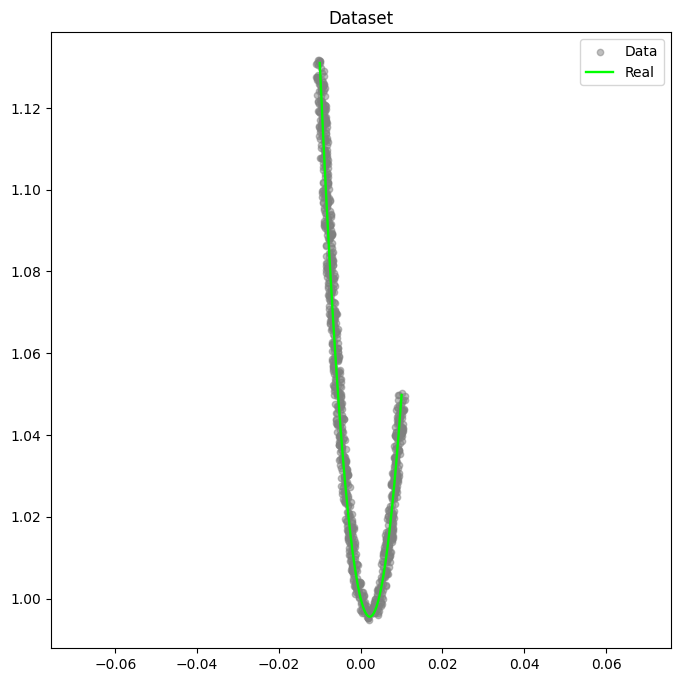

In [10]:
import torch


dataset_name = '1'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0], title="Dataset")

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

x_train_numpy, y_train_numpy = datasets[0][:, :-1], datasets[0][:, -1:]

eps_minimum = helper.mse_loss(f, real_w, x_train_numpy, y_train_numpy)
eps_minimum = eps_minimum*1.1

initial_w = np.array([-1.0, 0.1])

### Steps research

In [11]:
grad_methods = ['default', 'torch']


for grad_method in grad_methods:
    points, _, _, _ = train_our_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5, grad_method=grad_method)
    print(f'steps using {grad_method} grad: {len(points)}')

steps using default grad: 51
steps using torch grad: 51


In [12]:
_, grad_vectors_torch, grad_vectors_our, grad_vectors_nd = train_our_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5)

print('Torch grad:')
for grad in grad_vectors_torch:
    print('%8.20f   %8.20f' % (grad.tolist()[0], grad.tolist()[1]))
    # print(*(grad.tolist()))

print('Our grad:')
for grad in grad_vectors_our:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

print('numdifftool:')
for grad in grad_vectors_nd:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

Torch grad:
-0.00146706559993418353   -0.00014721156217214419
-0.00131440381007861076   -0.00019862055033065729
-0.00115017868325912698   -0.00026529536823679037
-0.00098270545906523413   -0.00034802171896141434
-0.00081524242312956447   -0.00044880610181326469
-0.00064997539121770982   -0.00056915770982797010
-0.00048876757840174716   -0.00070843865959252538
-0.00033324917015788809   -0.00086124012937570827
-0.00018461357509757609   -0.00101364661511797152
-0.00004326946487710602   -0.00113922553783827956
0.00009140787557679871   -0.00119670109529797708
0.00022089677448042079   -0.00113153853885099515
0.00034667664738087674   -0.00088338417520541720
0.00046852553227293852   -0.00040385765291219727
0.00046852553227293852   -0.00040385765291219727
0.00056427361890579229   0.00026522380641711438
0.00056427361890579229   0.00026522380641711438
0.00056427361890579229   0.00026522380641711438
0.00056427361890579229   0.00026522380641711438
0.00056427361890579229   0.00026522380641711438
0.0